In [3]:
from IPython.core.debugger import set_trace

%load_ext nb_black

import pandas as pd
import numpy as np
import numpy
import os
import matplotlib.pyplot as plt
import time

from tensorflow.keras.utils import to_categorical

from nltk.corpus import stopwords
import nltk

from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

from collections import Counter

from keras.preprocessing.text import Tokenizer

from keras_preprocessing.sequence import pad_sequences

from imblearn.over_sampling import SMOTE

from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from keras.initializers import Constant
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping


import random
import re


from sklearn.model_selection import train_test_split
import pickle
from sklearn.metrics import accuracy_score

plt.style.use(style="seaborn")
%matplotlib inline


The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black


<IPython.core.display.Javascript object>

In [5]:
def remove_URL(text):
    url = re.compile(r"https?://\S+|www\.\S+")
    return url.sub(r"", text)


def remove_html(text):
    html = re.compile(r"<.*?>")
    return html.sub(r"", text)

def remove_emoji(string):
    emoji_pattern = re.compile(
        "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        "]+",
        flags=re.UNICODE,
    )
    return emoji_pattern.sub(r"", string)

def decode(text):
    return " ".join([reverse_word_index.get(i, "?") for i in text])

import string

def counter_word(text):
    count = Counter()
    for i in text.values:
        for word in i.split():
            count[word] += 1
    return count

stop = set(stopwords.words("turkish"))

def remove_stopwords(text):
    text = [word.lower() for word in text.split() if word.lower() not in stop]

    return " ".join(text)

def remove_punct(text):
    table = str.maketrans("", "", string.punctuation)
    return text.translate(table)

<IPython.core.display.Javascript object>

In [7]:
df = pd.read_csv(f"stemmed_titles_hiphop_jazz.csv")
#df = df.rename({'music_genre': 'genre'}, axis=1) 


<IPython.core.display.Javascript object>

In [8]:
gnrlist = df.genre.unique()
gnrlist
#drout = 0.8 # random.uniform(0.1,0.9)

array(['Electronic', 'Anime', 'Jazz', 'Alternative', 'Country', 'Hip-Hop',
       'Rock', 'Classical'], dtype=object)

<IPython.core.display.Javascript object>

In [9]:
df['genre'] = df['genre'].map({"Electronic" : 0,"Anime" : 1,"Jazz" : 2,"Alternative" : 3,"Country" : 4,"Hip-Hop" : 5, "Rock": 6, "Classical": 7})

<IPython.core.display.Javascript object>

In [10]:
df["track_name"] = df.track_name.map(lambda x: remove_URL(x))
df["track_name"] = df.track_name.map(lambda x: remove_html(x))
df["track_name"] = df.track_name.map(lambda x: remove_emoji(x))
df["track_name"] = df.track_name.map(lambda x: remove_punct(x))
df['track_name'] = df['track_name'].str.lower()
df["track_name"]

0          röyksopp night out
1              the shine path
2                    hurrican
3                       nitro
4               divid conquer
                 ...         
49995                go getta
49996        drama feat drake
49997    lovin me feat smiggz
49998       shawti is da shit
49999          hip hop hooray
Name: track_name, Length: 50000, dtype: object

<IPython.core.display.Javascript object>

In [9]:
"""

#THIS IS FOR STEMMING THE WORDS. WE HAVE STEMMED THE WORDS BEFORE SO THERE IS NO NEED TO THIS AGAIN. THE CSV FILE ALREADY HAS STEMMED WORDS.

ps = PorterStemmer() 
stem_list = []
sentence_list = list(df['track_name'])
for i in range(0, 50000):
    stem_temp = []
    #print(sentence_list[i])
    for word in sentence_list[i].split():
        word = ps.stem(word)
        stem_temp.append(word)
    stem_list.append(stem_temp)
    #print(stem_temp)

df['track_name'] = stem_list
df.to_csv("stemmed_titles.csv", index = False)
"""

'\nps = PorterStemmer() \nstem_list = []\nsentence_list = list(df[\'track_name\'])\nfor i in range(0, 50000):\n    stem_temp = []\n    #print(sentence_list[i])\n    for word in sentence_list[i].split():\n        word = ps.stem(word)\n        stem_temp.append(word)\n    stem_list.append(stem_temp)\n    #print(stem_temp)\n\ndf[\'track_name\'] = stem_list\ndf.to_csv("stemmed_titles.csv", index = False)\n'

<IPython.core.display.Javascript object>

In [11]:
max_length = 10
text = df.track_name
genres = df.genre
counter = counter_word(text)
num_words = len(counter)

<IPython.core.display.Javascript object>

In [13]:
from sklearn.model_selection import train_test_split

train_sentences, test_sentences, train_labels, test_labels = train_test_split(text, genres, test_size = 0.2, shuffle=True)
#x_train

<IPython.core.display.Javascript object>

In [16]:
train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

<IPython.core.display.Javascript object>

In [17]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(train_sentences)
tokenizer.fit_on_texts(test_sentences)

word_index = tokenizer.word_index

<IPython.core.display.Javascript object>

In [18]:
from keras_preprocessing.sequence import pad_sequences

train_sequences = tokenizer.texts_to_sequences(train_sentences)
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding="post", truncating="post")

test_sequences = tokenizer.texts_to_sequences(test_sentences)
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding="post", truncating="post")

reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

<IPython.core.display.Javascript object>

In [19]:
len(test_labels)

10000

<IPython.core.display.Javascript object>

In [21]:
model=Sequential()
model.add(Embedding(num_words,256,input_length=max_length))
#model.add(Bidirectional(LSTM(32, return_sequences=True)))
model.add(LSTM(64,input_shape=(3,),activation='relu',return_sequences=True))

model.add(Dropout(0.5))
model.add(Dense(32,activation='relu'))
model.add(LSTM(16,activation='relu'))
model.add(Dense(8,activation='softmax'))

model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

earlystopper = EarlyStopping(monitor='val_loss', min_delta=0, patience=25, verbose=0, mode='auto')
history = model.fit(train_padded, train_labels, epochs=5, validation_data=(test_padded, test_labels), callbacks = [earlystopper], verbose = 1)

history_dict=history.history

Epoch 1/5
1250/1250 [==============================] - 84s 65ms/step - loss: 1.7548 - accuracy: 0.3336 - val_loss: 1.6561 - val_accuracy: 0.3730
Epoch 2/5
1250/1250 [==============================] - 84s 67ms/step - loss: 1.4756 - accuracy: 0.4614 - val_loss: 1.6041 - val_accuracy: 0.4123
Epoch 3/5
1250/1250 [==============================] - 82s 66ms/step - loss: 1.2651 - accuracy: 0.5418 - val_loss: 1.6483 - val_accuracy: 0.4117
Epoch 4/5
1250/1250 [==============================] - 82s 66ms/step - loss: 1.1185 - accuracy: 0.5954 - val_loss: 1.7926 - val_accuracy: 0.4049
Epoch 5/5
1250/1250 [==============================] - 80s 64ms/step - loss: 1.0154 - accuracy: 0.6240 - val_loss: 1.8750 - val_accuracy: 0.4008


<IPython.core.display.Javascript object>

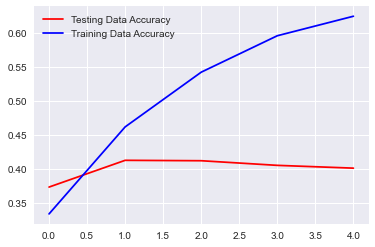

<IPython.core.display.Javascript object>

In [22]:
accuracy_values = history_dict['accuracy']
val_accuracy_values=history_dict['val_accuracy']
plt.plot(val_accuracy_values,'-r',label='Testing Data Accuracy')
plt.plot(accuracy_values,'-b',label='Training Data Accuracy')
plt.legend()

Text(0.5, 0, 'Epochs')

<Figure size 432x288 with 0 Axes>

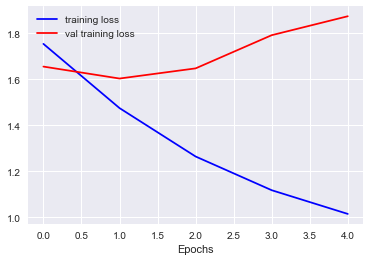

<IPython.core.display.Javascript object>

In [23]:
loss_values = history_dict['loss']
val_loss_values=history_dict['val_loss']
plt.figure()
plt.figure()
plt.plot(loss_values,'b',label='training loss')
plt.plot(val_loss_values,'r',label='val training loss')
plt.legend()
plt.xlabel("Epochs")

In [24]:
# Calculate loss and accuracy of testing data
loss, acc = model.evaluate(test_padded, test_labels)
print("Test loss: ", loss)
print("Test accuracy: ", acc)

313/313 [==============================] - 1s 5ms/step - loss: 1.8750 - accuracy: 0.4008
Test loss:  1.8749672174453735
Test accuracy:  0.4007999897003174


<IPython.core.display.Javascript object>

In [25]:
from sklearn.metrics import classification_report,confusion_matrix
import seaborn as sns

<IPython.core.display.Javascript object>

In [26]:
y_pred = model.predict(test_padded)

313/313 [==============================] - 2s 5ms/step


<IPython.core.display.Javascript object>

In [27]:
rounded_labels_pred=np.argmax(y_pred, axis=1)

rounded_labels_test=np.argmax(test_labels, axis=1)


<IPython.core.display.Javascript object>

In [28]:
print(classification_report(rounded_labels_test, rounded_labels_pred, digits=4))

              precision    recall  f1-score   support

           0     0.3665    0.2008    0.2594      1046
           1     0.5978    0.4306    0.5006       994
           2     0.3831    0.3882    0.3856      2004
           3     0.1357    0.1098    0.1214       993
           4     0.2658    0.3628    0.3068       951
           5     0.4578    0.5761    0.5102      2062
           6     0.1772    0.1759    0.1766       938
           7     0.7455    0.7757    0.7603      1012

    accuracy                         0.4008     10000
   macro avg     0.3912    0.3775    0.3776     10000
weighted avg     0.3997    0.4008    0.3941     10000



<IPython.core.display.Javascript object>

In [29]:
cm = confusion_matrix(rounded_labels_test, rounded_labels_pred)
cm_df = pd.DataFrame(cm,
                     index = gnrlist,
                     columns = gnrlist,
                     )

<IPython.core.display.Javascript object>

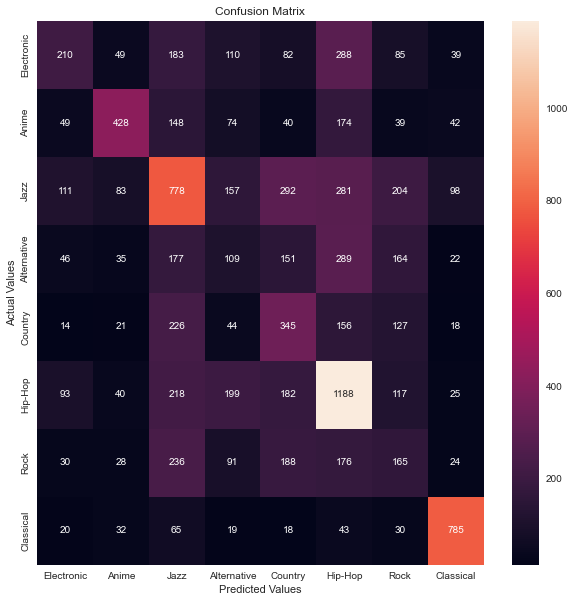

<IPython.core.display.Javascript object>

In [30]:
plt.figure(figsize=(10,10))
sns.heatmap(cm_df,annot=True, fmt='g')
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()